## BMI-206 Course Project
### Group 3 
#### Members:
- Xintong (Zoe) Chen
- Isobel Beasley
- Abolfazl (Abe) Arab

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from glob import glob

In [2]:
def read_multiple_files(files):
    
    dfs = {}

    for name, file in files:
        df = pd.read_csv(file, sep='\t', header=0).dropna(axis=1, how='all')
        print(name, df.shape)
        df.insert(df.shape[-1], column='source', value=name)
        dfs[name] = df

    return dfs

___

### GWAS data and analysis
[issue link](https://github.com/abearab/BMI-206-Class-Project/issues/2)

___
First, running @IJbeasley codes to gather fine-mapping data from the GWAS catalog.

In [3]:
# !bash code/finemap/download_finemap.sh 

In [33]:
fine_map_df = pd.read_csv(
    "data/fine_map/all_finngen_trait_cs_filtered.tsv",
    sep='\t'
)

fine_map_df['seqnames'] = fine_map_df['region'].str.split(':').str[0]
fine_map_df['starts'] =  fine_map_df['region'].str.split(':').str[1].str.split('-').str[0].astype(int)
fine_map_df['ends'] =    fine_map_df['region'].str.split(':').str[1].str.split('-').str[1].astype(int)

fine_map_df = fine_map_df.set_index(['seqnames', 'starts', 'ends']).reset_index()

The columns were best explained here: https://github.com/FINNGEN/finemapping-pipeline?tab=readme-ov-file#phenonamesusiesnpfiltertsv

___

#### Fig 4. a-c
(GWAS Manhattan plot by @IJbeasley)

In [34]:
##################### Figure 4a. ################# 

# 6q15
# 93100001-99500000 hg19 ucsc browser
# 92390283-99052124 liftover from hg19 to hg38
# in hg38 88000001-93100000 ucsc browser


######################## Figure 4 b. ####################### 
# 4p15.2

# 21300001-27700000 hg19
# 21298378-27698378 hg38


##################### Figure 4c ######################### 
# 11p14.1
# hg38 liftover 27178454-30978453
# hg19 27200001-31000000

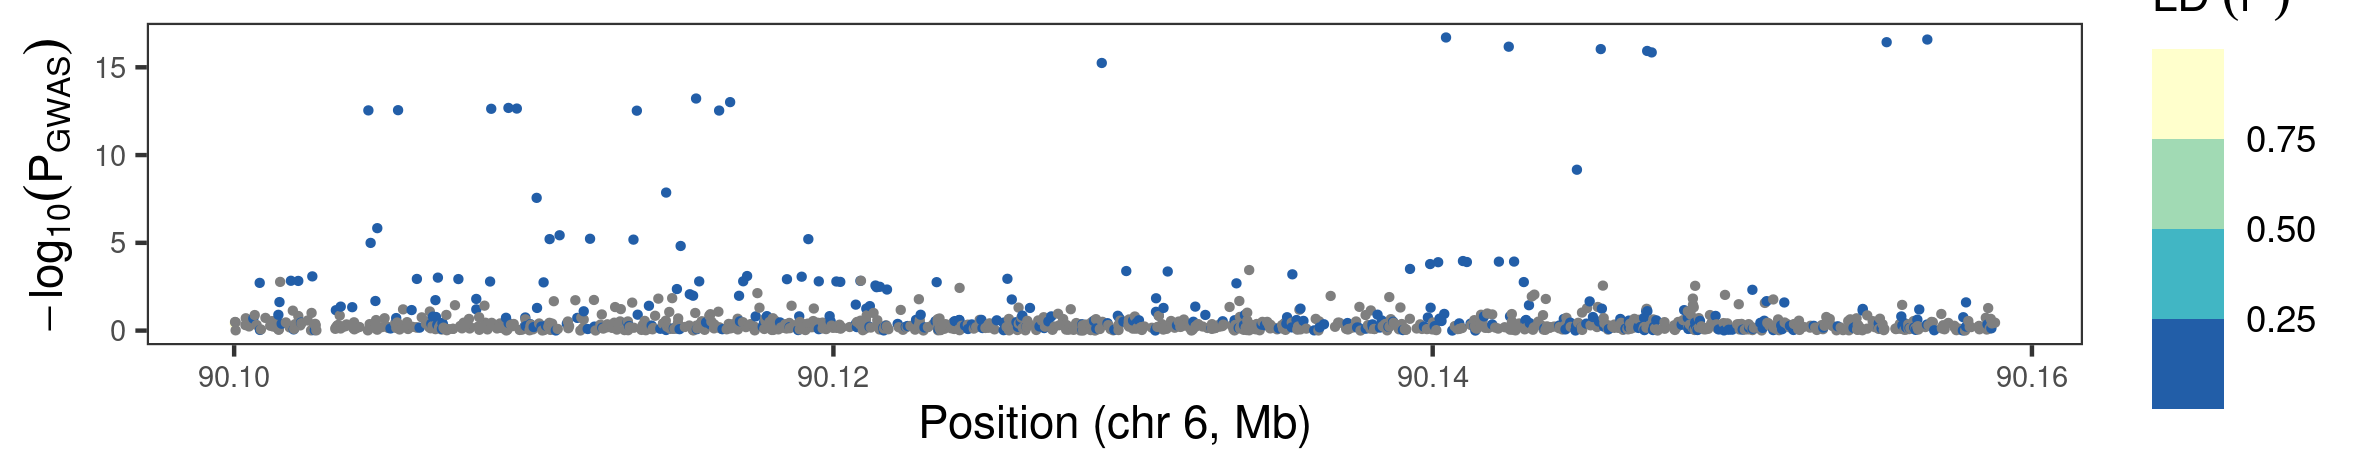

In [35]:
%matplotlib inline
from IPython.display import Image

# show a png file
Image(filename='figures/t1d_uk_bb.h.filt.fig4a.png')

### Single-cell data and analysis
[issue link](https://github.com/abearab/BMI-206-Class-Project/issues/3)

data: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE243917

___
R Scripts

In [36]:
# suppressMessages(suppressWarnings(library('SCENT')))
# suppressMessages(suppressWarnings(library('Seurat')))
# suppressMessages(suppressWarnings(library('SingleCellExperiment')))
# suppressMessages(suppressWarnings(library('tidyverse')))
# suppressMessages(suppressWarnings(library('anndata')))

In [37]:
# library('Matrix')

In [38]:
# # Create SingleCellExperiment objects that points to on-disk H5AD file
# rna_h5ad_file = 'data/GSE243917_genesXcells_ALL_raw.h5ad'
# atac_h5ad_file = 'data/GSE243917_peaksXcells_ALL_raw.h5ad'

# rna <- anndata::read_h5ad(rna_h5ad_file)
# atac <- anndata::read_h5ad(atac_h5ad_file)

# # Convert to dgCMatrix using Matrix package
# rna$X <- Matrix(rna$X, "dgCMatrix")
# atac$X <- Matrix(atac$X, "dgCMatrix")

In [39]:
# SCENT_obj <- SCENT::CreateSCENTObj(
#     rna = rna$X,
#     atac = atac$X,
#     meta.data = rna$obs,
#     peak.info = atac$obs,
#     covariates = c("log(nUMI)","percent.mito","sample", "batch"), 
#     celltypes = "ct" # cell type column
# )

___

| Column | Descriptions | 
| ------ | ------------ |
| gene | The gene(-peak) pair in each test statistics
| peak | The (gene-)peak pair in each test statistics
| beta | The regression coefficient from primary Poisson regression
| se | The standard error from primary Poisson regression
| z | The Z score from primary Poisson regression
| p | The raw p value from primary Poisson regression
| boot_basic_p | The bootstrap p value calculated from bootstrapping analyses

In [46]:
def read_scent_output(file):
    
    res = pd.read_csv(file, sep=' ')

    res['seqnames'] = res['peak'].str.split(':').str[0]
    res['starts'] = res['peak'].str.split(':').str[1].str.split('-').str[0].astype(int)
    res['ends'] = res['peak'].str.split(':').str[1].str.split('-').str[1].astype(int)

    res['-log10(p)'] = -np.log10(res['p'])
    res['-log10(boot_basic_p)'] = -np.log10(res['boot_basic_p'])

    res = res.set_index(['seqnames', 'starts', 'ends','peak','gene']).reset_index()

    return res

In [47]:
ls data/scent-results/

500kb_fibroblast_allcvar_part.txt.gz  500kb_Tcell_nocvar_parts.txt.gz
500kb_Tcell_allcvar.txt.gz


In [48]:
res_Tcell_allcvar = read_scent_output('data/scent-results/500kb_Tcell_allcvar.txt.gz')
res_Tcell_nocvar = read_scent_output('data/scent-results/500kb_Tcell_nocvar_parts.txt.gz')
res_fibroblast_allcvar_part = read_scent_output('data/scent-results/500kb_fibroblast_allcvar_part.txt.gz')

/pollard/home/aabe/miniconda3/envs/SCENT/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/pollard/home/aabe/miniconda3/envs/SCENT/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/pollard/home/aabe/miniconda3/envs/SCENT/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [49]:
fine_map_df.groupby('trait').size().sort_values(ascending=False)

trait
RX_STATIN                    46
I9_HYPERTENSION              35
I9_HYPTENS                   33
T2D_INCLAVO                  32
RX_ANTIHYP                   29
                             ..
AB1_VIRAL_HEPATITIS           1
AB1_VIRAL_HEMOR_FEVER_NOS     1
AB1_OTHER_VIRAL               1
AB1_OTHER_SEPSIS              1
AB1_OTHER_BACTERIAL           1
Length: 795, dtype: int64

In [50]:
fine_map_df.query(
    'seqnames == "chr6" and starts >= 90 * 10**6 and ends <= 90.3 * 10**6'
)

,seqnames,starts,ends,trait,region,v,cs,cs_specific_prob,chromosome,position,allele1,allele2,maf,beta,p,se,most_severe,gene_most_severe


In [51]:
res_Tcell_allcvar.query(
    'seqnames == "chr6" and starts >= 90 * 10**6 and ends <= 90.3 * 10**6 and gene == "BACH2"'
)

,seqnames,starts,ends,peak,gene,beta,se,z,p,boot_basic_p,-log10(p),-log10(boot_basic_p)
47435,chr6,90080937,90081137,chr6:90080937-90081137,BACH2,0.334452,0.017441,19.175763,5.899626e-82,0.00004,81.229176,4.397940
47436,chr6,90081170,90081370,chr6:90081170-90081370,BACH2,0.346913,0.019435,17.850034,2.888585e-71,0.00004,70.539315,4.397940
47437,chr6,90103494,90103694,chr6:90103494-90103694,BACH2,0.300484,0.023503,12.784854,1.992367e-37,0.00004,36.700631,4.397940
47438,chr6,90234047,90234247,chr6:90234047-90234247,BACH2,0.479856,0.019962,24.038582,1.099013e-127,0.00004,126.958997,4.397940
47439,chr6,90274493,90274693,chr6:90274493-90274693,BACH2,0.390684,0.014536,26.876827,4.098743e-159,0.00004,158.387349,4.397940
47440,chr6,90284334,90284534,chr6:90284334-90284534,BACH2,0.214471,0.021332,10.054154,8.807433e-24,0.00004,23.055151,4.397940
47441,chr6,90284751,90284951,chr6:90284751-90284951,BACH2,0.143390,0.017409,8.236660,1.770850e-16,0.00104,15.751818,2.982967
47442,chr6,90285685,90285885,chr6:90285685-90285885,BACH2,0.102682,0.021089,4.869006,1.121610e-06,0.04160,5.950158,1.380907
47443,chr6,90295185,90295385,chr6:90295185-90295385,BACH2,0.081502,0.021779,3.742245,1.823834e-04,0.16000,3.739015,0.795880
47444,chr6,90295409,90295609,chr6:90295409-90295609,BACH2,0.150422,0.021603,6.963177,3.326839e-12,0.00584,11.477968,2.233587


In [52]:
# set(fine_map_df['region']) & set(res_1['peak'].to_list())

In [53]:
# # bed file
# # columns: chr, start, end, p
# res_1_bed = pd.concat(
#     {
#         'chr':res_1['peak'].str.split(':').str[0],
#         'start':res_1['peak'].str.split(':').str[1].str.split('-').str[0].astype(int),
#         'end':res_1['peak'].str.split(':').str[1].str.split('-').str[1].astype(int),
#         'name':res_1['gene']+'::'+res_1['peak'],
#         'score':res_1['beta'],
#         # 'strand':pd.Series('.',index=res_1.index),
#     },axis=1
# )

In [54]:
# res_1_bed.to_csv('data/zoe-scent-results/500kb_Tcell_allcvar.bed', sep='\t', index=False, header=False)

In [55]:
# res_1 = res_Tcell_allcvar

# # draw volcano plot of z vs -log10(p) and color by source

# fig, axes = plt.subplots(2,2, figsize=(9,9))

# res_1.plot.scatter(x='z', y='-log10(boot_basic_p)', alpha=0.5, ax=axes[0,0])
# res_1.plot.scatter(x='beta', y='-log10(boot_basic_p)', alpha=0.5, ax=axes[0,1])
# res_1.plot.scatter(x='z', y='-log10(p)', alpha=0.5, ax=axes[1,0])
# res_1.plot.scatter(x='beta', y='-log10(p)', alpha=0.5, ax=axes[1,1])

# plt.suptitle('500kb_Tcell_allcvar', fontsize=20)
# plt.tight_layout()
# plt.show()

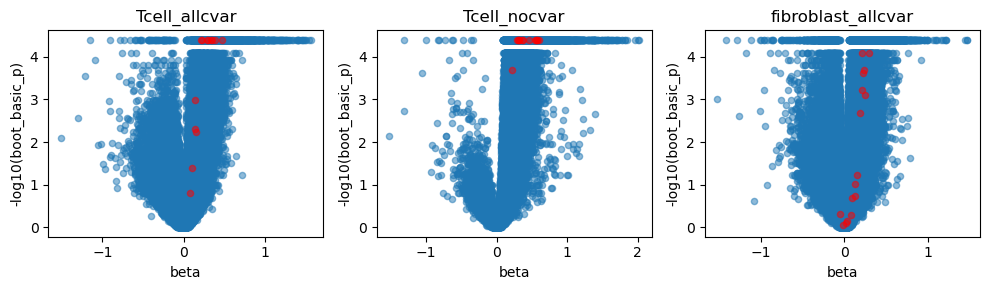

In [57]:
fig, axes = plt.subplots(1,3, figsize=(10,3))


for i, (name, res) in enumerate({
    'Tcell_allcvar':res_Tcell_allcvar,
    'Tcell_nocvar':res_Tcell_nocvar,
    'fibroblast_allcvar':res_fibroblast_allcvar_part,
}.items()): 
    
    res.plot.scatter(x='beta', y='-log10(boot_basic_p)', alpha=0.5, ax=axes[i])
    res.query(
        'seqnames == "chr6" and starts >= 90 * 10**6 and ends <= 90.3 * 10**6 and gene == "BACH2"'
    ).plot.scatter(x='beta', y='-log10(boot_basic_p)', alpha=0.5, ax=axes[i], color='red')

    axes[i].set_title(name)

plt.tight_layout()
plt.show()

___
preprocessed files from the SCENT paper:

In [58]:
# files = [
#     (os.path.basename(file).replace('_allqced_bootpkg_nopc_allCT.FDR0.10.txt.gz',''), file)
#     for file in glob('data/enhancer-gene-links-from-the-paper/*.txt.gz')
# ]

In [59]:
# dfs = read_multiple_files(files)

# df = pd.concat(dfs.values())
# df['-log10(p)'] = -np.log10(df['p'])
# df['-log10(boot_p)'] = -np.log10(df['boot_p'])

In [60]:
# fig, ax = plt.subplots(figsize=(5,5))

# df.plot.scatter(
#     x='beta', y='-log10(boot_p)', 
#     alpha=0.5, 
#     c=df['source'].astype('category').cat.codes, 
#     cmap='tab20', 
#     ax=ax
# )

# plt.show()

### Enrichment analysis
[issue link](https://github.com/abearab/BMI-206-Class-Project/issues/5)

**Aim:** Causal variant enrichment analysis

**Tasks:**
- [ ] Reimplement enrichment analysis similar to the SCENT paper
- [ ] 

related links:
- https://biocpy.github.io/GenomicRanges/tutorial.html#overlap-based-methodsm

___
From our proposal:
> To replicate and expand upon the paper’s disease enrichment analysis of the causal variants identified with SCENT, we will create a set of disease causal variants by filtering the FinnGen fine-mapping results for the most reliable identified fine-mapped traits (e.g., number of case > 1,000) and variants (high purity of casual sets). 

> To evaluate the SCENT’s outcome, Sakaue et al. defined and evaluated causal enrichment for GWAS, eQTLs, caQTL or other ground truth resources such as bulk or single-cell-based enhancer–gene maps (Fig 3, S6-S8). We found this as a useful part of the paper to focus on for more in-depth statistical analysis. We will implement a “causal variant enrichment analysis” formula through custom codes in R or python. As we move forward, we will decide what exact analysis we can perform. We have lots of examples from the sub-figures but we can also go beyond that, for instance we can evaluate what are the effects of changing covariates in the SCENT pipeline.


___

We defined causal variant enrichment statistics for GWAS within SCENT enhancers and other annotations by using statistically fine-mapped variants from FinnGen79 and UK Biobank80 that we described in the previous section. We selected variants with PIP >0.2 as putatively causal variants for primary analyses.

\begin{array}{l}{{{\mathrm{Enrichment}}}}_{{{\mathrm{trait}}}{\rm{\_}}i}\\=\displaystyle\frac{{\!\,}^{\displaystyle{\rm{\#}}{{{\mathrm{causal}}}{\rm{\_}}\mathrm{var}{\rm{\_}}{{\mathrm{in}}}{\rm{\_}}{{\mathrm{annot}}}}_{{{\mathrm{trait}}}{\rm{\_}}i}}\!\left/{\vphantom{\sum^2_8}}{\!\!\,}_{\displaystyle\sum {{{\mathrm{common}}}{\rm{\_}}\mathrm{var}{\rm{\_}}{{\mathrm{in}}}{\rm{\_}}{{\mathrm{annot}}}}_{{{\mathrm{trait}}}{\rm{\_}}i}}\right.}{{\!\,}^{\displaystyle{{\rm{\#}}{{\mathrm{causal}}}{\rm{\_}}\mathrm{var}}_{{{\mathrm{trait}}}{\rm{\_}}i}}\!\left/{\vphantom{\sum^2_8}}{\!\!\,}_{\displaystyle\sum {{{\mathrm{common}}}{\rm{\_}}\mathrm{var}{\rm{\_}}{{\mathrm{across}}}{\rm{\_}}{{\mathrm{loci}}}}_{{{\mathrm{trait}}}{\rm{\_}}i}}\right.}\end{array}


```math
{{\mathrm{Overall}}}{{\,}}{{\mathrm{Enrichment}}}=\frac{1}{n}\mathop{\sum }\limits_{i=1}^{n}{{{\mathrm{Enrichment}}}}_{{{\mathrm{trait}}}{\rm{\_}}i}
```

For each trait i, we divided the number of putatively causal variants within an annotation (across all loci for trait i) normalized by the number of common variants within an annotation by the number of all causal variants for trait i normalized by the number of all common variants within all significant loci analyzed for the trait i. To calculate common variants within annotation or within locus, we again used 1000 Genomes Project variants with minor allele frequency >1% in European population. To derive Overall Enrichment score, we took the mean across all the traits.

For each trait i and putative causal gene pair, we calculated the distance between the TSS of the gene and the most likely causal variant which had the largest PIP when multiple variants were nominated for a single gene by SCENT (Supplementary Fig. 6a). For each putative causal gene for the trait i, we also sorted all the genes on the basis of the distance between the gene’s TSS and the most likely causal variant (from the smallest to the largest). We then obtained the rank of the putative causal gene from SCENT among the sorted gene list to see how often the SCENT gene is the closest gene from the most likely causal variant.

___

In [ ]:
def cal_enrichment_trait(num_enhancers, num_enhancers_in_fine_map, num_enhancers_in_scent):
    
    num_enhancers = len(set(num_enhancers))
    num_enhancers_in_fine_map = len(set(num_enhancers_in_fine_map))
    num_enhancers_in_scent = len(set(num_enhancers_in_scent))
    
    enrichment_fine_map = num_enhancers_in_fine_map / num_enhancers
    enrichment_scent = num_enhancers_in_scent / num_enhancers
    
    return enrichment_fine_map, enrichment_scent

In [161]:
from genomicranges import GenomicRanges


def run_overlap(subject, query):
    # # find Overlaps
    # res = subject.find_overlaps(query, query_type="within")
    
    # # count Overlaps
    # res = subject.count_overlaps(query)

    # subset by Overlaps
    res = subject.subset_by_overlaps(query, query_type="within")

    return res

___

In [162]:
fine_map_gr = GenomicRanges.from_pandas(fine_map_df)

In [174]:
boot_basic_p__threshold = 3

res_fibroblast_allcvar_part_gr = GenomicRanges.from_pandas(res_fibroblast_allcvar_part.query(f'`-log10(boot_basic_p)` > {boot_basic_p__threshold}'))
res_Tcell_allcvar_gr = GenomicRanges.from_pandas(res_Tcell_allcvar.query(f'`-log10(boot_basic_p)` > {boot_basic_p__threshold}'))
res_Tcell_nocvar_gr = GenomicRanges.from_pandas(res_Tcell_nocvar.query(f'`-log10(boot_basic_p)` > {boot_basic_p__threshold}'))

In [188]:
for name, res in {
    'Tcell_allcvar':res_Tcell_allcvar_gr,
    'Tcell_nocvar':res_Tcell_nocvar_gr,
    'fibroblast_allcvar':res_fibroblast_allcvar_part_gr,
}.items():
    
    ol1 = run_overlap(
        subject = res,
        query = fine_map_gr
    )

    ol2 = run_overlap(
        subject = fine_map_gr,
        query = res
    )

    print(f'{name}:\n\t\t{len(ol1)} {len(ol2)}\n')


Tcell_allcvar:
		3398 2196

Tcell_nocvar:
		19265 2440

fibroblast_allcvar:
		5119 2295



In [177]:
res_fibroblast_allcvar_part

,seqnames,starts,ends,peak,gene,beta,se,z,p,boot_basic_p,-log10(p),-log10(boot_basic_p)
0,chr1,225881771,225881971,chr1:225881771-225881971,PARP1,0.012305,0.074531,0.165094,0.868870,0.84,0.061045,0.075721
1,chr1,225882323,225882523,chr1:225882323-225882523,PARP1,-0.009326,0.038833,-0.240159,0.810207,0.78,0.091404,0.107905
2,chr1,225882967,225883167,chr1:225882967-225883167,PARP1,0.052001,0.052843,0.984066,0.325083,0.36,0.488006,0.443697
3,chr1,225911404,225911604,chr1:225911404-225911604,PARP1,-0.054494,0.053322,-1.021983,0.306789,0.34,0.513160,0.468521
4,chr1,225924237,225924437,chr1:225924237-225924437,PARP1,0.017019,0.036459,0.466789,0.640651,0.62,0.193379,0.207608
...,...,...,...,...,...,...,...,...,...,...,...,...
336497,chr1,9627065,9627265,chr1:9627065-9627265,UBE4B,0.042740,0.033919,1.260066,0.207646,0.30,0.682677,0.522879
336498,chr1,9644772,9644972,chr1:9644772-9644972,UBE4B,-0.016541,0.051556,-0.320830,0.748339,0.80,0.125902,0.096910
336499,chr1,9687328,9687528,chr1:9687328-9687528,UBE4B,-0.022576,0.049000,-0.460732,0.644991,0.54,0.190446,0.267606
336500,chr1,9689394,9689594,chr1:9689394-9689594,UBE4B,0.043799,0.033011,1.326805,0.184573,0.28,0.733831,0.552842


In [168]:
len(res_fibroblast_allcvar_part_gr), len(res_fibroblast_allcvar_part_overlap)

(336502, 262018)

In [158]:
from sklearn.metrics import precision_recall_curve

# https://www.datacamp.com/tutorial/precision-recall-curve-tutorial

In [160]:
help(
    precision_recall_curve
)

Help on function precision_recall_curve in module sklearn.metrics._ranking:

precision_recall_curve(y_true, y_score=None, *, pos_label=None, sample_weight=None, drop_intermediate=False, probas_pred='deprecated')
    Compute precision-recall pairs for different probability thresholds.

    Note: this implementation is restricted to the binary classification task.

    The precision is the ratio ``tp / (tp + fp)`` where ``tp`` is the number of
    true positives and ``fp`` the number of false positives. The precision is
    intuitively the ability of the classifier not to label as positive a sample
    that is negative.

    The recall is the ratio ``tp / (tp + fn)`` where ``tp`` is the number of
    true positives and ``fn`` the number of false negatives. The recall is
    intuitively the ability of the classifier to find all the positive samples.

    The last precision and recall values are 1. and 0. respectively and do not
    have a corresponding threshold. This ensures that the gra

In [ ]:

precision, recall, thresholds = precision_recall_curve(y_train, y_prob_train)
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Train Precision-Recall curve");



In [ ]:
# plt.hist(res_fibroblast_allcvar_part_overlap, bins=100)

# plt.show()

In [120]:
results = []

for i, row_i in res_Tcell_allcvar.iterrows():
    for j, row_j in fine_map_df.iterrows():
        # check if row i is within row j
        if row_i['seqnames'] == row_j['seqnames'] and row_i['starts'] >= row_j['starts'] and row_i['ends'] <= row_j['ends']:
            results.append([i, j])

KeyboardInterrupt: 

In [ ]:
results

###

In [ ]:
%reload_ext watermark
%watermark
%watermark --iversions

Last updated: 2024-11-19T11:31:04.324646-08:00

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.29.0

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 4.18.0-477.27.1.el8_8.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

pandas: 2.2.3

